![](imagenes/UC_FMRI.jpg)

---

---

***Andres Eduardo Aracena Rangel***

*Estudiante del programa del Magister en Física Médica*

---

---


El siguiente Script de Python forma parte del trabajo especial de grado.

Profesora Guía:

*PhD María Daniela Cornejo*

---

---

&nbsp;
Con referencia:

- [Pagina oficial NIbabel](https://nipy.org/nibabel/index.html) 

Imagenes de fMRI extraidas de OpenNuero:
 
 - [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)
 
---

---

 Acronimos:

- CSF: Cerebrospinal Fluid (*líquido cefalorraquídeo*)
- GM: Gray Matter (*materia gris*)
- WM: White Matter (*materia blanca*)

---

---

NOTA:
Cuando indiquemos imagenes brain o mascaras brain, nos estamos refieriendo a las imagenes o mascaras de csf, wm, gm

---

---

# Regresión regresión lineal múltiple mediante el  método de mínimo cuadrado ordinarios.

Para encontrar el modelo de regresión lineal múltiple que mejor se ajusta a la variable dependiente, usaremos el método de mínimo cuadrado ordinarios (OLS, de las siglas en ingles de Ordinary Least Squares).

## Importamos librerias


In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj   # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)
import matplotlib.pyplot as plt   # Permite la generación de gráficos
import pandas as pd               #Biblioteca para manipulación de marcos de datos
import numpy as np
from numpy import random
import nibabel as nib

import matplotlib.patches as mpatches


#Biblioteca para estimar modelos estadísticos y realizar pruebas estadísticas
import statsmodels.api as sm

## Definimos parámetros

In [3]:
'''
Ruta del directorio de la data
'''
path_data = '/home/aracena/thesis_ds002422/' 

# ruta donde reposa la imagen funcional procesada con bet

path_fmri = opj(path_data,'02_fase1_extraccion_brain_fmri_prepro','output')

#ruta mascaras brain
path_brain = opj(path_data,'01_fase1_extraccion_mask_brain','output','datasink','masks_brain')

'''
Ruta donde reposan las series promedios brain en archivo csv
'''
# Ruta donde reposan las series brain
path_csv = opj(path_data,'03_fase2_extraccion_series_tiempo_brain', 'output', '0.95', 'archivos_csv')

'''
Ruta donde reposan las series promedios 'brain' y 'series aleatorias' en archivo csv
'''
path_series = opj(path_data,'04_fase2_promedio_series_tiempo_brain','output','0.95', 'archivos_csv')

'''
Ruta donde se guardaran los resultados
'''
path_output = opj(path_data,'08_fase5_analisis_estadistico_aic/', 'output')
path_png = opj(path_output,'archivos_png')
               
# Crear la carpeta de salida
os.system('mkdir -p %s'%path_output)
os.system('mkdir -p %s'%path_png)

'''
Creamos la carpeta de salida para tablas
'''
path_out_DF = opj(path_output,'tablas_proyecto')
os.system('mkdir -p %s'%path_out_DF)


'''
lista de tejidos a procesar
'''
tejido = ['csf', 'gm', 'wm']

        
'''
Ingrese el umbral que desea extraer (se extrajeron tres mask brain para tres umbrales distintos)
'''
umbral_sel = '0.95'

## Funciones

### Función para graficar series de tiempo

In [4]:
'''
Función grafica las series de tiempo de una DF introducida. Se requiere input:

- df_data = Dataframe que contiene las series de tiempo
- name_save = nombre con que desea guardar el grafico
'''

def plot_series_time(df_data, resaltar, titulo, name_save): 
    # Creamos una lista con las claves del diccionario ingresado
    tejido = list(df_data.keys())
    # definimos una ventana
    vent_min = 50
    vent_max = 75


    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, ax = plt.subplots(figsize = (17,8))
    for i,tisue in enumerate(tejido):
        if resaltar[0] == 'all':
            ax.plot(df_data[tisue], linewidth=2, label=tisue)
        elif i < len(resaltar):
            ax.plot(df_data[resaltar[i]], linewidth=2, label=tisue)
        else:           
            ax.plot(df_data[tisue], linewidth=1, label=tisue)

    ax.legend()
    ax.set_xlabel('Tiempo ($\\tau_N$)',fontdict=font1)
    ax.set_ylabel('Señal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')

    plt.savefig(opj(path_png, name_save))

### Función crear lista de las series de un DF (lista de los valores de la columna del DF) y eliminar series

In [5]:
'''
Función  que extrae una lista de los valores de las columnas de un dataframe.

Inputs:

- df: Dataframe que se desea extrae una lista de los valores de las columnas,
- elmiminar: lista de los valores de las columnas del DF que desea eliminar. Se debe ingresar una lista:
        * NO eliminar ningun valor de las columnas DF --> ['none']
        * Elimimnar uno o mas valores de la lista --> ['nombre_1' , 'nombre_2']
        
        LOS VALORES DEBE ESTAR EN FORMATO STRING (entre comillas simples o dobles)

Output:

- list_series: lista de series del DF
'''

def lista_dataframe(df, eliminar):
    # Creamos una lista de las columnas del dataframe
    series = df.columns.values
    list_series = list(series)
    
    tam = len(eliminar)

    if tam == 1:
        if eliminar[0] == 'none':
            list_series
        else:
            list_series.remove(eliminar[0]) 
    if tam != 1:   
        for i in range(tam):
            list_series.remove(eliminar[i])        
    
    return list_series    

### Función de conjunto potencia ó de número de combinaciones

En matemáticas, dado un conjunto $S$, se llama conjunto potencia o conjunto de partes de $S$ (se denota por $P(S)$ o $2^S$) al conjunto formado por todos los subconjuntos posibles de $S$.

Por ejemplo, si $S= {a, b, c}$ entonces el conjunto potencia de $S$ es 

*P(S) = {{ }, {a}, {b}, {c}, {a, b}, {a, c}, {b, c}, {a, b, c} }*

In [6]:
'''
Función para extraer todos los subconjuntos posibles de un conjunto de una lista de entrada.

Inputs:

- lista_conjunto: Lista donde se desea extraer el conjunto potencia
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- r: Lista de las combinaciones/modelos.
'''

def potencia(list_conjunto):
    '''
    Calcula y devuelve el conjunto potencia del conjunto c.
    En matemáticas, el conjunto potencia de un conjunto dado es otro conjunto 
    formado por todos los subconjuntos del conjunto dado.
    '''
   
    # Número de combinaciones
    if len(list_conjunto) == 0:
        return [[]]
    r = potencia(list_conjunto[:-1])
    
    return r + [s + [list_conjunto[-1]] for s in r]

### Funcion para crear un dataframe de las combinaciones/modelos

In [7]:
'''
Función para visualizar las combinaciones/modelos en un dataframe, para ser incorporada en documentos.

Inputs:

- lista_combi: Lista de combinaciones/modelos 
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- df_combi: Dataframe con las combinaciones/modelos
'''


def crear_df_combi(lista_combi, columnas):
    combi = lista_combi
    '''
    ordenamos la lista
    '''
    combi.sort()
    
    '''
    Se reescribe el elemento lista de la lista en un solo valor, 
    que es la combinacion/modelo
    '''

    list_combi =[]
    beta = str('$\\beta$')
    for i, co in enumerate(combi):
        modelo= beta+str(0)
        for j, mo in enumerate(combi[i]):
            modelo = modelo + ' + ' + beta + str(j+1) + ' ' + mo
        list_combi.append(modelo)   
    
    '''
    PROCESO DE CONVERTIR DE LISTA 1D A UN DATAFRAME FIL X COLUM
    '''
    # Indique cuantas columnas quiere representar las combinaciones en un DF
    colum = columnas

    # Como se quiere crear una matriz de 'colum' columnas, 
    # verifico si 'long' es divisible entre 'colum'; de no ser serlo, 
    # agrego un elemneto vacio a la lista hasta conseguirlo
    long = len(list_combi)
    n=0
    while n==0:
        if long % colum == 0: 
            n=1
        else:
            list_combi.append('')
            long = len(list_combi)
            
    # Conviertimos la lista en un array
    co = np.array(list_combi)

    # Conviertimos un array de 1D a laa dimension fil x colum
    fil = int(long/colum) # numero de filas

    co = co.reshape(fil,colum)

    # Convertirmos la matriz fil x colum en un DF
    df_combi = pd.DataFrame(co)

    '''
    Cambiamos nombre de columnas
    '''
    #Creamos lista de nuevos nombres
    new_colum = []
    for i in range(colum):
        new_colum.append('Combinaciones / Modelos')

    df_combi.columns = new_colum

    '''
    Renombramos indice
    '''
    #Creamos diccionario de nuevos indices
    new_index = {}
    for i in range(fil):
        new_index[i]= ' '

    #renombramos indices
    df_combi.rename(index=new_index, inplace=True)
    
    return df_combi    

In [8]:
'''
Función para visualizar las combinaciones/modelos en un dataframe, para ser incorporada en documentos.

Inputs:

- lista_combi: Lista de combinaciones/modelos 
- columnas: Numero de columnas para ordenar las combinaciones/modelos

Output:

- df_combi: Dataframe con las combinaciones/modelos
'''


def crear_df_combi_1(lista_combi, columnas):
    '''
    ordenamos la lista
    '''
    combi.sort()
    
    '''
    Se reescribe el elemento lista de la lista en un solo valor, 
    que es la combinacion/modelo
    '''
    le = len(combi)
    list_combi =[]
    for i, co in enumerate(combi):
        ser = co
        w = len(ser)
        for i, se in enumerate(ser):
            if i == 0:
                agr = se
            else:
                agr = agr + ' + ' + se
        list_combi.append(agr)
        
    '''
    PROCESO DE CONVERTIR DE LISTA 1D A UN DATAFRAME FIL X COLUM
    '''
    # Indique cuantas columnas quiere representar las combinaciones en un DF
    colum = columnas

    # Como se quiere crear una matriz de 'colum' columnas, 
    # verifico si 'long' es divisible entre 'colum'; de no ser serlo, 
    # agrego un elemneto vacio a la lista hasta conseguirlo
    long = len(list_combi)
    n=0
    while n==0:
        if long % colum == 0: 
            n=1
        else:
            list_combi.append('')
            long = len(list_combi)
            
    # Conviertimos la lista en un array
    co = np.array(list_combi)

    # Conviertimos un array de 1D a laa dimension fil x colum
    fil = int(long/colum) # numero de filas

    co = co.reshape(fil,colum)

    # Convertirmos la matriz fil x colum en un DF
    df_combi = pd.DataFrame(co)

    '''
    Cambiamos nombre de columnas
    '''
    #Creamos lista de nuevos nombres
    new_colum = []
    for i in range(colum):
        new_colum.append('Combinaciones / Modelos')

    df_combi.columns = new_colum

    '''
    Renombramos indice
    '''
    #Creamos diccionario de nuevos indices
    new_index = {}
    for i in range(fil):
        new_index[i]= ' '

    #renombramos indices
    df_combi.rename(index=new_index, inplace=True)
    
    return df_combi    

### Función aplicacion modelo OLS

In [9]:
'''
df_analisis: Dataframe que contien la serie dependiente (variable dependiente o variable de respuesta)
                y las series predictoras (ariables independientes o variables predictoras)
var_depen: Variable dependiente del dataframe (serie a predecir)
modelo: modelo a predecir la variable dependiente

Output: 

aic, r2, r2_adj, model: estadistios
'''


def estadisticos(df_analisis, var_depen, modelo):
    # Y: normalmente significa la variable respuesta (variable dependiente o variable de respuesta)
    #define response variable
    Y = df_analisis[var_depen]

    # X: usualmente significa nuestras variables de entrada (variables independientes o variables predictoras)
    X = df_analisis[modelo]

    #agregar constante a las variables predictoras [intercepción (beta_0) al modelo]
    X = sm.add_constant(X)

    #ajustamos modelo de regresión
    model = sm.OLS(Y, X).fit()    # sm.OLS(respuesta, entrada)

    #guardamos estadisticos AIC, R2, R2-AJUSTADO
    aic = model.aic
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    
    return aic, r2, r2_adj, model

### Función para determinar el mejor modelo mediante modelo de regresión OSL

In [10]:
def best_osl(df_depen, df_indep, var_depen, lista_combi):
    
    '''
    CReamos una lista de las series del corte de la var dep
    '''
    num_ser  = df_var_depen.columns.to_list()

    a = pd.DataFrame()
    b = pd.DataFrame()
    aa = pd.DataFrame()
    bb = pd.DataFrame()
    aaa = pd.DataFrame()
    bbb = pd.DataFrame()
    for i, nuser in enumerate(num_ser):
        #creamos una lista que identifica la serie del voxel, con la camtidad de combinaciones
        serie = []
        for j in enumerate(lista_combi):
            serie.append(nuser)
        #se crea dataframe que identifica voxel en estudio
        df_serie = pd.DataFrame(serie, columns=['serie'])

        #extraemos la serie de tiempo del voxel i
        serie_estudio = df_depen.iloc[:,[i]]
        serie_estudio.columns=[var_depen]

        analisis = pd.merge(serie_estudio, df_indep,
                               right_index=True,left_index=True)

        #Ejecutamos la funcion aic
        RESULTADO_AIC = {}
        RESULTADO_R2 = {}
        RESULTADO_R2_AJU = {}
        modelo = {}
        for i, c in enumerate(lista_combi):
            li = lista_combi[i]
            anali = estadisticos(df_analisis=analisis,
                                 var_depen= var_depen,
                                 modelo=li)
            AIC = round(anali[0],2)
            R2 = round(anali[1],4)
            R2_AJU = round(anali[2],4)        
            c = ','.join(c)
            RESULTADO_AIC[c] = AIC
            RESULTADO_R2[c] = R2
            RESULTADO_R2_AJU[c] = R2_AJU
            modelo[c] = anali[3]


        '''
        DataFrame AIC
        '''
        #representamos el resultado aic en un dataframe
        DF_AIC = pd.DataFrame(list(RESULTADO_AIC.items()),
                       columns=['MODELO', 'AIC'])

        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_AIC = pd.merge(DF_AIC,DF_MODELO, on='MODELO')

        #ordenamos de mayor a menor
        DFM_AIC = DF_AIC.sort_values('AIC')

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_AIC.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_aic = pd.merge(df_serie, DFM_AIC,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_aic = best_model_aic.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            a = best_model_aic
            b = best_aic
        else:
            best_model_aic = pd.concat([a, best_model_aic])
            best_aic = pd.concat([b, best_aic])
            a = best_model_aic
            b = best_aic

        #restablecer el índice
        best_model_aic.reset_index(drop=True, inplace=True)
        best_aic.reset_index(drop=True, inplace=True)


        '''
        DataFrame R2
        '''

        #representamos el resultado aic en un dataframe
        DF_R2 = pd.DataFrame(list(RESULTADO_R2.items()),
                       columns=['MODELO', 'R2'])
        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO_R2 = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_R2 = pd.merge(DF_R2,DF_MODELO_R2, on='MODELO')


        #ordenamos de mayor a menor
        DFM_R2 = DF_R2.sort_values('R2',ascending=False)

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_R2.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_r2 = pd.merge(df_serie, DFM_R2,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_r2 = best_model_r2.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            aa = best_model_r2
            bb = best_r2
        else:
            best_model_r2 = pd.concat([aa, best_model_r2])
            best_r2 = pd.concat([bb, best_r2])
            aa = best_model_r2
            bb = best_r2

        #restablecer el índice
        best_model_r2.reset_index(drop=True, inplace=True)
        best_r2.reset_index(drop=True, inplace=True)


        '''
        DataFrame R2-ajustado
        '''
        #representamos el resultado aic en un dataframe
        DF_R2_AJU = pd.DataFrame(list(RESULTADO_R2_AJU.items()),
                       columns=['MODELO', 'R2-ajus'])

        #representamos el resultado del modelo(resultado de la regresión
        # lineal) en un dataframe
        DF_MODELO_R2_AJU = pd.DataFrame(list(modelo.items()),
                       columns=['MODELO', 'resultado_regresión'])

        # Unimos DF de resultado aic con DF modelo
        DF_R2_AJU= pd.merge(DF_R2_AJU,DF_MODELO_R2_AJU, on='MODELO')

        #ordenamos de mayor a menor
        DFM_R2_AJU = DF_R2_AJU.sort_values('R2-ajus',ascending=False)

        #restablecer el índice (para poder eliminar luego los dos ultimos)
        DFM_R2_AJU.reset_index(drop=True, inplace=True)

        #unimos DFM con la identificacion del voxel
        best_model_aju = pd.merge(df_serie, DFM_R2_AJU,
                           right_index=True,left_index=True)

        #elegimos el mejor modelo del voxel en estudio
        be = 1
        en =  len(lista_combi)
        best_r2_aju = best_model_aju.drop(range(1, en, 1),axis=0)

        if i == 0:
            # creamos a y b para concatenar los demas resultados
            aaa = best_model_aju
            bbb = best_r2_aju
        else:
            best_model_aju = pd.concat([aaa, best_model_aju])
            best_r2_aju = pd.concat([bbb, best_r2_aju])
            aaa = best_model_aju
            bbb = best_r2_aju

        #restablecer el índice
        best_model_aju.reset_index(drop=True, inplace=True)
        best_r2_aju.reset_index(drop=True, inplace=True)

    return  best_aic, best_model_aic, best_r2, best_model_r2, best_r2_aju, best_model_aju, 
    #print(DFM_R2)
    #print('\n',best_model)
    #print('\n', best_aic)

### Función para extraer los valores p de los regresores

In [11]:
'''
Función para extraer los valores p de las variables regresoras y su analisis con respecto al nivel 
significancia. Se requiere como inputs:

- df_ana = DF que se desea analisar y que debe contener los resultados de la regresión lineal
- nivel_signif = Nivel de significancia, si es de 5%, ingresamos 0.05, 
                                         si es del 10%, ingresamos 0.1, etc

Como output obtendremos un DF con el analisis sobre el valor p en los regresores
'''


def analisi_p(df_anali, nivel_signif):
    import pandas as pd
    '''
    Extraemos el primer indice de la DF a analizar. Esto se realiza, ya que en el analisis podremos escojer 
    los mejores aic de un conjunto de series que no empiece en el voxel/serie cero, por ejemplo, 
    puedo escojer los voxels del valor 4865 al 9728 que corresponden al segundo corte, y si utilizamos 
    el ciclo for desde 0, nos cambiara la identificación del voxel para para ser ingresado a la DF; 
    por ejemplo, el primer voxel al pasar por el ciclo es el 4865, y el ciclo lo guaradara 
    como 0
    '''

    inicio = df_anali.index.start

    '''
    Extraemos los valores p
    '''
    tam = len(df_anali)

    df_coef = pd.DataFrame()
    df_suma = pd.DataFrame()
    for i in range(tam):
        #extraemos resultados de la regresión lineal (RL) de las series de la imagen
        best_model = df_anali['resultado_regresión'][i+inicio]     
        indice = inicio + i
        #creamos DF de los valores p de la RL de la serie
        df_co = pd.DataFrame(round(best_model.pvalues,2)).T
        df_co.index = [indice]    

        #concatenamos
        df_coef = pd.concat([df_coef,df_co])

        #extraemos nombre de las columnas (regresores) en una lista; se extraee de la lista antes de concaenar
        regresores = df_co.columns.values  
        list_regresor = list(regresores)

        suma_evaluacion = 0
        valores_p = [] # creamos una lista para guardar los valores p y luego anexarla al DF best_aic

        for i, re in enumerate(list_regresor):
            coef = df_coef[re][indice]
            if coef < nivel_signif:
                suma_evaluacion = suma_evaluacion
            else:
                suma_evaluacion = suma_evaluacion + 1

            valores_p.append(coef)

        '''
        Agregamos el resultado de la lista de valores p de los regresores y 
        la suma_evaluación al DF en evaluación
        '''
        df_su = pd.DataFrame()
        df_su['valores_p_regresores'] = [valores_p]
        df_su['suma_evaluación'] = [suma_evaluacion]
        df_su.index = [indice]

        # concatenamos
        df_suma = pd.concat([df_suma,df_su])

    '''
    Unimos en un DF el resultado final
    '''
    analisis_p = pd.merge(df_coef, df_suma,
                       right_index=True,left_index=True)
    '''
    Unimos con la DF analisi_p con la DF de entrada
    '''
    best_p_1 = pd.merge(df_anali, analisis_p,
                           right_index=True,left_index=True)

    # eliminamos la columna resultado_regresión, 
    best_p = best_p_1.drop(['resultado_regresión'], axis=1)
    
    '''
    Crearemos un DF donde anexaremos una nueva columna, donde al evaluar suma_evaluacion si es 0, 
    agregamos el modelo AIC, si es mayor a cero, agregamos la palabra 'Pout', indicandonos que el
    modelo iene un valor p matyor a 0.05
    '''
    modelo_p = pd.DataFrame()

    for i in range(tam):
        valeva = best_p['suma_evaluación'][i+inicio]

        model_p = pd.DataFrame()
        if valeva == 0:
            model_p['MODELO_P'] = [best_p['MODELO'][i+inicio]]
        else:
            model_p['MODELO_P'] = ['Pout']

        model_p.index = [i+inicio]
        modelo_p = pd.concat([modelo_p,model_p])
    '''
    UNIMOS DF
    '''
    df_anali_p = pd.merge(best_p, modelo_p,
                     right_index=True,left_index=True)
    
    return df_anali_p

In [12]:
'''
Función para extraer los valores p de las variables regresoras y su analisis con respecto al nivel 
significancia. Se requiere como inputs:

- df_ana = DF que se desea analisar y que debe contener los resultados de la regresión lineal
- nivel_signif = Nivel de significancia, si es de 5%, ingresamos 0.05, 
                                         si es del 10%, ingresamos 0.1, etc

Como output obtendremos un DF con el analisis sobre el valor p en los regresores
'''


def analisi_p_1(df_anali, nivel_signif):
    import pandas as pd
    '''
    Extraemos el primer indice de la DF a analizar. Esto se realiza, ya que en el analisis podremos escojer 
    los mejores aic de un conjunto de series que no empiece en el voxel/serie cero, por ejemplo, 
    puedo escojer los voxels del valor 4865 al 9728 que corresponden al segundo corte, y si utilizamos 
    el ciclo for desde 0, nos cambiara la identificación del voxel para para ser ingresado a la DF; 
    por ejemplo, el primer voxel al pasar por el ciclo es el 4865, y el ciclo lo guaradara 
    como 0
    '''

    inicio = df_anali.index.start

    '''
    Extraemos los valores p
    '''
    tam = len(df_anali)

    df_coef = pd.DataFrame()
    df_suma = pd.DataFrame()
    for i in range(tam):
        #extraemos resultados de la regresión lineal (RL) de las series de la imagen
        best_model = df_anali['resultado_regresión'][i+inicio]     
        indice = inicio + i
        #creamos DF de los valores p de la RL de la serie
        df_co = pd.DataFrame(round(best_model.pvalues,2)).T
        df_co.index = [indice]   

        #concatenamos
        df_coef = pd.concat([df_coef,df_co])

        #extraemos nombre de las columnas (regresores) en una lista; se extrae de la lista antes de concaenar
        regresores = df_co.columns.values  
        list_regresor = list(regresores)

        suma_evaluacion = 0
        valores_p = [] # creamos una lista para guardar los valores p y luego anexarla al DF best_aic
        
        # El la evaluación, no tomamos en cuenta el valor p de la constante
        for i in range(len(list_regresor)-1):            
            coef = df_coef[list_regresor[i+1]][indice]
            if coef < nivel_signif:
                suma_evaluacion = suma_evaluacion
            else:
                suma_evaluacion = suma_evaluacion + 1

            valores_p.append(coef)

        '''
        Agregamos el resultado de la lista de valores p de los regresores y 
        la suma_evaluación al DF en evaluación
        '''
        df_su = pd.DataFrame()
        df_su['valores_p_regresores_ser'] = [valores_p]
        df_su['suma_evaluación'] = [suma_evaluacion]
        df_su.index = [indice]

        # concatenamos
        df_suma = pd.concat([df_suma,df_su])

    '''
    Unimos en un DF el resultado final
    '''
    analisis_p = pd.merge(df_coef, df_suma,
                       right_index=True,left_index=True)
    '''
    Unimos con la DF analisi_p con la DF de entrada
    '''
    best_p_1 = pd.merge(df_anali, analisis_p,
                           right_index=True,left_index=True)

    # eliminamos la columna resultado_regresión, 
    best_p = best_p_1.drop(['resultado_regresión'], axis=1)
    
    '''
    Crearemos un DF donde anexaremos una nueva columna, donde al evaluar suma_evaluacion si es 0, 
    agregamos el modelo AIC, si es mayor a cero, agregamos la palabra 'Pout', indicandonos que el
    modelo iene un valor p matyor a 0.05
    '''
    modelo_p = pd.DataFrame()

    for i in range(tam):
        valeva = best_p['suma_evaluación'][i+inicio]

        model_p = pd.DataFrame()
        if valeva == 0:
            model_p['MODELO_P'] = [best_p['MODELO'][i+inicio]]
        else:
            model_p['MODELO_P'] = ['Pout']

        model_p.index = [i+inicio]
        modelo_p = pd.concat([modelo_p,model_p])
    '''
    UNIMOS DF
    '''
    df_anali_p = pd.merge(best_p, modelo_p,
                     right_index=True,left_index=True)
    
    return df_anali_p

### Función para graficar la variable dependiente en un modelo de OSL y el resultado del mejor modelo

In [13]:
'''
Función para graficar la variable dependiente en un modelo de OSL y el resultado del mejor modelo 
mediante modelo de regresión OSL.

Inputs:

- df_depen = Dataframe de la variable dependiente del modelo de OSL 
- models_osl = Dataframe de los modelos de regresion al aplicar la funcion 'best_osl'. Ingresar solo
                el resultado segun alguno de los estadistico de AIC, R2 o R2_adjustado.
- best = seleccionar el modelo que quiere graficar. Si desea graficar el mejor modelo, se ingresa 0; 
        si desea graficar el segundo mejor modelo, se ingresa 1, y asi sucesivamente.
- titulo = titulo de la grafica
- name_save = nombre con el que se desea guardar la grafica
'''

def plot_series_osl(df_depen, models_osl, best, titulo, name_save): 
    '''
    Elegimos el modelo segun variable input best
    '''
    best_model= models_osl['resultado_regresión'][best]
    print(best_model.summary())
    
    '''
    Crear la etiqueta del mejor modelo
    '''

    for i, mo in enumerate(models_osl['MODELO'][best]):
        mo=models_osl['MODELO'][best].split(',') #Split regresa una lista de las palabras en la cadena, 
                                 # usando separador como el delimitador.

    '''
    Creamos nombre con los coeficientes y series del mejor modelo
    '''
    beta = str('$\\beta$')
    modelo_win = df_depen.columns.values[0]+' = '+beta+str(0)
    for i, m in enumerate(mo):
        modelo_win = modelo_win + ' + ' + beta + str(i+1) + m 
    
    '''
    Creamos etiqueta de la variable dependiente
    '''
    label_depen = df_depen.columns.values
    label_depen = label_depen[0]
    
    '''
    Dataframe del modelo de regresion OSL
    '''
    df_osl = pd.DataFrame(best_model.fittedvalues)
    df_osl.columns = ['modelo OLS']    
    
    # definimos una ventana
    vent_min = 50
    vent_max = 75


    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}

    fig, ax = plt.subplots(figsize = (17,8))
    ax.plot(df_depen, linewidth=2, label=label_depen)
    ax.plot(df_osl, '--.', linewidth=2, color = 'red', label=modelo_win)

    ax.legend()
    ax.set_xlabel('Tiempo ($\\tau_N$)',fontdict=font1)
    ax.set_ylabel('Señal fMRI',fontdict=font1)
    ax.set_title(titulo, fontdict = font2)
    ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')
    ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
    ax.axvspan(vent_min,vent_max, alpha=0.3, facecolor='y')

    plt.savefig(opj(path_png, name_save))

### Función para comparar los modelos segun los estadisticos AIC, R2 Y R2 ajustado

In [14]:
'''
Función que genera un dataframe de comparacion de los modelos segun los estadisticos AIC, R2 Y R2 ajustado.

Inputs:

aic = DF modelos segun el estadistico AIC (DF resultante de la funcion 'best_osl')
r2 = DF modelos segun el estadistico R2 (DF resultante de la funcion 'best_osl')
r2_ajus = DF modelos segun el estadistico R2_ajus (DF resultante de la funcion 'best_osl')
'''

def compara_models_estad(aic,r2,r2_ajus):
    df_aic_best = aic_all.copy()
    df_aic_best = df_aic_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df_r2_best = r2_all.copy()
    df_r2_best = df_r2_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df_r2_aju_best = r2_ajus_all.copy()
    df_r2_aju_best = df_r2_aju_best.drop(['serie', 'resultado_regresión'], axis=1)
    
    df4 = pd.merge(df_aic_best,df_r2_best,on='MODELO',how='left')
    df5 = pd.merge(df4,df_r2_aju_best,on='MODELO',how='left')

    df5.style.highlight_max(axis=0)
    
    return     df5.style.\
                    highlight_max(subset=['AIC'], color='salmon').\
                    highlight_min(subset=['AIC'], color='yellow').\
                    highlight_max(subset=['R2','R2-ajus'], color='yellow').\
                    highlight_min(subset=['R2','R2-ajus'], color='salmon').\
                    format({'id':'{:.0f}'})
    

### Función agregar la posición x,y,z a los voxel/series de un DF y una caracteristica

In [15]:
'''
Función agregar la posición x,y,z a los voxel/series de un DF. Se requiere como inputs:

- voxel_posicion = DF de la posición de los voxeles en x,y,z
- df_anali = DF que se desea anexarle la posición delos voxels
- carac = caracteristica/variable que desea anexar al nuevo DF junto con a posición de los voxels

Como output obtendremos un DF con la posición de los voxels y la caracteristica seleccionada
'''

def dataframe_posicion(voxel_posicion, df_anali, carac):  
    '''
    Extraemos el mejor modelo con evaluacion del valor p
    '''
    sel_model_p = df_anali[[carac]]

    '''
    Unimos DF
    '''

    df_anali_voxels = pd.merge(voxel_posicion, sel_model_p,
                            right_index=True,left_index=True)
    return df_anali_voxels

### Función para visualizar resultado de la regresión lineal en un corte

In [16]:
def visual_analis_corte_sagital(df_sel, datos_img_fis, vol, corte_selec,df_color):    
    '''
    Visualizamos
    '''
    vol_img_data = datos_img_fis[:, :, :, vol]
    corte_coro = vol_img_data[:, :, corte_selec]

    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    titulo =['func_prepro_bet con mejor AIC \n Corte Axial: ' + str(corte_selec), 
             'func_prepro_bet\n Corte Axial: ' + str(corte_selec)]

    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    axes[0].imshow(corte_coro, cmap = 'Wistia')
    axes[1].imshow(corte_coro , cmap = 'gray')
    
    #Extraemos una lista del indice
    lista_indice = df_sel.index.to_list()

    for i,lis in enumerate(lista_indice):
        k = df_sel['MODELO_P'][lis]
        color = df_color['color'][k]

        axes[0].scatter(df_sel['y'][lis],df_sel['z'][lis], 
                          marker="s",edgecolor='white', 
                          color=color,linewidth=2,  s=40)            
        axes[0].axis('off')

    for i,title in enumerate(titulo):
        axes[i].set_title(title, fontdict=font2)

    #creamos leyenda
    list_label = list(df_color.index)

    leyen = []
    for i, la in enumerate(list_label):
        le = mpatches.Patch(color=df_color['color'][la], label=la)
        leyen.append(le)
    
    axes[0].legend(handles=leyen,loc = 'lower center',ncol=4)
    
    fig.patch.set_facecolor('xkcd:white')
    plt.show()
    
    return df_sel

### Función para visulizar solo los modelos que se ajustan a wm en un corte

In [17]:
def visual_solo_wm(df_sel, datos_img_fis, vol, corte_selec):    
    '''
    Visualizamos
    '''
    vol_img_data = datos_img_fis[:, :, :, vol]
    corte_coro = vol_img_data[:, :, corte_selec]

    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    titulo =['mask_gm con mejor aic \n Corte Axial: ' + str(corte_selec), 
             'mask_gm\n Corte Axial: ' + str(corte_selec)]

    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    axes[0].imshow(corte_coro, cmap = 'gray')
    axes[1].imshow(corte_coro , cmap = 'gray')
    
    #Extraemos una lista del indice
    lista_indice = df_sel.index.to_list()
    
    for i,lis in enumerate(lista_indice):
        k = df_sel['MODELO_P'][lis]
        if k == 'ser_mask_wm':
            colore = 'green'
            le_1 = mpatches.Patch(color=colore, label=k)
            axes[0].scatter(df_sel['y'][lis],df_sel['z'][lis], 
                              marker="s",edgecolor='white', 
                              color=colore,linewidth=2,  s=40)
            axes[0].axis('off')


    for i,title in enumerate(titulo):
        axes[i].set_title(title, fontdict=font2)

    fig.patch.set_facecolor('xkcd:white')
    axes[0].legend(handles=[le_1],loc = 'lower center',ncol=4)
    #axes[0].legend(handles=[le_2],loc = 'lower center',ncol=4)
    plt.show()
    
    return df_sel

### Funcion para visualizar resultado dela regresón lineal solo en los voxels que dan forma la mascara

In [18]:
def visual_analis_mask(df_sel, mascara, vol, corte_selec,df_color):    
    '''
    Visualizamos
    '''
    vol_img_data = datos_img[mascara][:, :, :, vol]
    corte_coro = vol_img_data[:, :, corte_selec]

    font1 = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'}
    font2  = {'fontsize':18, 'fontweight':'bold', 'color':'tab:red'}
    titulo =[mascara + ' con mejor aic \n Corte Axial: ' + str(corte_selec), 
             mascara + '\n Corte Axial: ' + str(corte_selec)]

    fig, axes = plt.subplots(1, 2, figsize=(20, 20))

    axes[0].imshow(corte_coro, cmap = 'gray')
    axes[1].imshow(corte_coro , cmap = 'gray')
    
    #Extraemos una lista del indice
    lista_indice = df_sel.index.to_list()

    for i,lis in enumerate(lista_indice):
        k = df_sel['MODELO_P'][lis]
        color = df_color['color'][k]

        axes[0].scatter(df_sel['y'][lis],df_sel['z'][lis], 
                          marker="s",edgecolor='white', 
                          color=color,linewidth=2,  s=40)            
        axes[0].axis('off')

    for i,title in enumerate(titulo):
        axes[i].set_title(title, fontdict=font2)

    #creamos leyenda
    list_label = list(df_color.index)

    leyen = []
    for i, la in enumerate(list_label):
        le = mpatches.Patch(color=df_color['color'][la], label=la)
        leyen.append(le)
    
    axes[0].legend(handles=leyen,loc = 'lower center',ncol=4)
    
    fig.patch.set_facecolor('xkcd:white')
    plt.show()
    
    return df_sel

## Cargamos imagen y datos de la imagen funcional

In [19]:
img_func = 'fmri_prepro_bet.nii.gz'               # Nombre de la imagen funcional preprocesada con bet
img_func_orig = nib.load(opj(path_fmri,img_func)) # Cargamos imagen nifti
datos_func_orig = img_func_orig.get_fdata()       # Cargamos datos de la imagen

## Cargamos imagenes y datos de las mascaras del tejido cerebral

In [20]:
img_masks = 'fmri_rest_prepro.nii.gz'               # Nombre de las mascaras del tejido cerebral

'''
mask_csf
'''

mask_csf_orig = nib.load(opj(path_brain, 'mask_ext_csf','threshold_0.95', img_masks)) # Cargamos imagen nifti
datos_mask_csf= mask_csf_orig.get_fdata()                                         # Cargamos datos de la imagen

'''
mask_wm
'''

mask_wm_orig = nib.load(opj(path_brain, 'mask_ext_wm','threshold_0.95', img_masks)) # Cargamos imagen nifti
datos_mask_wm= mask_wm_orig.get_fdata()                                         # Cargamos datos de la imagen

'''
mask_gm
'''

mask_gm_orig = nib.load(opj(path_brain, 'mask_ext_gm','threshold_0.95', img_masks)) # Cargamos imagen nifti
datos_mask_gm= mask_gm_orig.get_fdata()                                         # Cargamos datos de la imagen

## Creamos Diccinario con los datos de las imagenes

In [21]:
datos_img={'func_prepro_bet': datos_func_orig, 'mask_csf': datos_mask_csf, 
           'mask_wm': datos_mask_wm , 'mask_gm': datos_mask_gm}

In [22]:
datos_img['mask_csf'].shape

(62, 62, 44, 196)

## Cargamos las series que conforman cada una de las imagenes
Las series de todos los voxels de la imagen funcional es extraida del notebook **02_fase2_extraccion_series_tiempo_brain**.

### Series de tiempo de la imagen funcional preprocesada bet

In [23]:
df_func = pd.read_csv (opj(path_csv,'serie_tiempo_all_func.csv'))
df_func

,0,1,2,3,4,5,6,7,8,9,...,169126,169127,169128,169129,169130,169131,169132,169133,169134,169135
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_func.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_func.columns = colum_name_int

'''
Verificamos
'''
#verificamos
df_func[125156]

0      602.551086
1      607.188904
2      591.853455
3      599.024963
4      587.435974
          ...    
191    596.145020
192    600.325745
193    594.977112
194    593.999084
195    590.688110
Name: 125156, Length: 196, dtype: float64

### Series de tiempo de la imagen mask_csf

In [25]:
pd.options.display.max_columns = 12 # para mejorar la visualización del DataFrame

df_csf = pd.read_csv(opj(path_csv,'serie_tiempo_all_mask_csf.csv'))
df_csf

,42789,42790,42791,42833,42834,42835,...,119218,119219,119220,119224,119225,119226
0,147.668701,199.851395,321.464417,319.859619,390.075043,485.286591,...,575.245911,564.928162,563.222595,571.135742,569.495667,573.659790
1,147.734985,203.295837,316.090210,320.602753,394.869293,489.250885,...,576.844482,574.859253,572.265747,574.809692,565.620789,569.487976
2,147.813690,198.290558,318.719666,324.457642,391.678802,484.849060,...,571.221802,582.090027,579.156067,568.527588,569.592651,570.382019
3,148.630875,207.636703,311.952423,325.447235,387.747406,489.182068,...,562.674438,564.800537,562.293640,570.185669,564.723206,571.315186
4,148.653290,203.587326,304.501617,329.378143,391.722839,488.992188,...,570.756592,564.414001,564.004456,575.846069,566.695435,577.148010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,141.190781,206.106812,308.748840,318.514404,415.739349,496.409668,...,567.523254,567.580322,570.030457,570.975403,568.758972,574.168945
192,148.696869,212.194748,314.824097,325.573364,412.295959,502.475403,...,575.559021,570.799500,576.565796,573.521729,570.436768,570.730591
193,152.130447,211.498489,313.927216,315.044403,415.206024,503.547485,...,582.249146,576.852112,569.587463,565.593323,567.328613,574.088501
194,146.669983,214.301300,301.381012,306.016785,417.359467,507.997894,...,571.097778,570.077942,573.925476,576.993652,574.053040,576.496826


In [26]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_csf.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_csf.columns = colum_name_int

'''
Verificamos
'''
df_csf[42789]

0      147.668701
1      147.734985
2      147.813690
3      148.630875
4      148.653290
          ...    
191    141.190781
192    148.696869
193    152.130447
194    146.669983
195    140.227005
Name: 42789, Length: 196, dtype: float64

### Series de tiempo de la imagen mask_wm

In [27]:
df_wm = pd.read_csv(opj(path_csv,'serie_tiempo_all_mask_wm.csv'))
df_wm

,45521,45522,45523,45565,45566,45567,...,149133,149134,149135,149177,149178,149179
0,558.509705,540.997253,541.389648,612.870605,588.416565,589.830811,...,707.064514,696.431885,692.887207,705.565552,682.213257,680.011780
1,557.310730,531.426636,531.750427,614.956848,591.456055,590.338989,...,707.434204,692.308960,688.676697,699.486694,686.828613,682.569702
2,553.042358,542.496765,542.752930,612.459534,588.968567,598.140747,...,706.353638,700.280396,695.907104,697.278992,682.359070,680.453552
3,556.084290,536.858459,537.048035,609.126282,580.387085,599.528992,...,703.976257,696.470581,690.543945,697.413391,687.366211,683.097656
4,552.461121,535.620850,535.744812,614.710693,584.458618,586.557007,...,705.783508,696.361450,691.490540,704.485046,686.238892,679.217285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,561.972473,529.630554,535.687500,614.773926,587.987854,587.687195,...,706.727905,695.396240,688.720825,699.697327,680.160156,678.870422
192,557.835083,536.516235,541.599182,609.853760,583.662842,583.317261,...,708.028015,696.687439,687.257263,702.897400,682.628296,680.961609
193,559.801941,531.376709,534.836853,609.734924,575.786438,575.395325,...,703.313477,693.849243,689.939636,694.144592,685.434326,684.456177
194,555.847839,542.341858,533.729126,616.521912,573.733948,573.296631,...,700.210693,692.626648,690.553711,694.869263,688.940613,687.568787


In [28]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_wm.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_wm.columns = colum_name_int

'''
Verificamos
'''
df_wm[45521]

0      558.509705
1      557.310730
2      553.042358
3      556.084290
4      552.461121
          ...    
191    561.972473
192    557.835083
193    559.801941
194    555.847839
195    553.873474
Name: 45521, Length: 196, dtype: float64

### Series de tiempo de la imagen mask_gm

In [29]:
df_gm = pd.read_csv(opj(path_csv,'serie_tiempo_all_mask_gm.csv'))
df_gm

,69984,69985,69986,70028,70029,70030,...,138011,138012,138013,138054,138055,138056
0,482.691833,483.875824,523.863342,500.585510,543.190735,562.234924,...,645.991577,620.883484,566.739197,604.856079,611.386292,608.635925
1,490.438690,490.441040,517.636902,499.352142,536.707214,559.764709,...,641.451172,617.706116,565.928284,607.190735,616.314758,612.303101
2,485.499817,484.313629,512.508789,502.541199,533.103638,558.305786,...,642.839539,626.015991,560.519287,603.756348,613.508911,611.362244
3,476.901245,484.134796,516.711487,492.174194,539.963135,557.129456,...,634.700623,620.761414,577.031738,596.944275,603.076233,608.359131
4,485.044861,488.924286,517.882935,494.482971,544.175903,557.237122,...,635.966248,614.508911,553.956726,606.033569,615.232788,603.548889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,479.272766,482.000244,520.089600,495.016785,538.495911,557.342529,...,636.059387,623.618591,569.794250,598.263672,613.219727,609.638550
192,484.100555,482.913391,516.416931,497.960968,550.385437,567.474548,...,631.828430,606.168701,565.765930,603.287720,609.638672,608.893311
193,484.148315,482.442291,520.879272,497.371368,547.918213,564.610901,...,628.325562,612.783081,564.594421,602.537537,611.554382,612.415527
194,484.834839,488.470093,519.455383,500.314392,543.865784,567.100037,...,629.879944,612.956604,568.226501,604.447266,611.404968,607.777649


In [30]:
'''
Verificamos si los nombres de las columnas son string o enteros
'''
colum_name = df_gm.columns.values

tipo = type(colum_name[0])

if tipo == str:
    '''
    Convertimos los nombres de columna en string a int
    '''
    colum_name_int = []
    for i,ne in enumerate(colum_name):
        colum_name_int.append(int(ne))

'''
Agregamos los nombres de la serie en entero
'''
df_gm.columns = colum_name_int

'''
Verificamos
'''
df_gm[69984]

0      482.691833
1      490.438690
2      485.499817
3      476.901245
4      485.044861
          ...    
191    479.272766
192    484.100555
193    484.148315
194    484.834839
195    484.571167
Name: 69984, Length: 196, dtype: float64

## Cargamos las series promedio global CSF, GM y WM.

In [31]:
'''
Cargamos la serie del csf
'''
df_csf = pd.read_csv (opj(path_series,'serie_tiempo_val_prom_ser_mask_csf.csv'))

'''
Cargamos la serie del gm
'''
df_gm = pd.read_csv (opj(path_series,'serie_tiempo_val_prom_ser_mask_gm.csv'))


'''
Cargamos la serie del wm
'''
df_wm = pd.read_csv (opj(path_series,'serie_tiempo_val_prom_ser_mask_wm.csv'))

## Cargamos las posiciones de los voxels de las imagenes

### Posición voxels imagen funcional preprocesada bet

In [32]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_func = pd.read_csv (opj(path_csv,'pos_vox_func.csv'))

# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_func = voxels_func.set_index('voxel/serie', drop=False)
voxels_func

,voxel/serie,z,y,x
voxel/serie,,,,
0,0,0,0,0
1,1,0,0,1
2,2,0,0,2
3,3,0,0,3
4,4,0,0,4
...,...,...,...,...
169131,169131,61,61,39
169132,169132,61,61,40
169133,169133,61,61,41


### Posición voxels imagen mask_csf

In [33]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_csf = pd.read_csv (opj(path_csv,'pos_vox_mask_csf.csv'))

# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_csf = voxels_csf.set_index('voxel/serie', drop=False)
voxels_csf

,voxel/serie,z,y,x
voxel/serie,,,,
42789,42789,15,42,21
42790,42790,15,42,22
42791,42791,15,42,23
42833,42833,15,43,21
42834,42834,15,43,22
...,...,...,...,...
119219,119219,43,43,23
119220,119220,43,43,24
119224,119224,43,43,28


### Posición voxels imagen mask_wm

In [34]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_wm = pd.read_csv (opj(path_csv,'pos_vox_mask_wm.csv'))

# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_wm = voxels_wm.set_index('voxel/serie', drop=False)
voxels_wm

,voxel/serie,z,y,x
voxel/serie,,,,
45521,45521,16,42,25
45522,45522,16,42,26
45523,45523,16,42,27
45565,45565,16,43,25
45566,45566,16,43,26
...,...,...,...,...
149134,149134,54,41,18
149135,149135,54,41,19
149177,149177,54,42,17


### Posición voxels imagen mask_gm

In [35]:
'''
Cargamos el archivo csv de las posicion de los voxels
'''
voxels_gm = pd.read_csv (opj(path_csv,'pos_vox_mask_gm.csv'))

# Convertimos la columna voxel/serie en indice, sin eliminar la columna
voxels_gm = voxels_gm.set_index('voxel/serie', drop=False)
voxels_gm

,voxel/serie,z,y,x
voxel/serie,,,,
69984,69984,25,40,24
69985,69985,25,40,25
69986,69986,25,40,26
70028,70028,25,41,24
70029,70029,25,41,25
...,...,...,...,...
138012,138012,50,36,28
138013,138013,50,36,29
138054,138054,50,37,26


## Seleccionar un corte y extraemos las series correspondientes a ese corte

### Selección del corte sagital

In [36]:
'''
Indicamos el corte sagital
'''
corte_sagital = 25

### Extraemos las series que corresponden al corte seleccionado en la imagen funcional

#### Extraemos las posiciones de los voxels del corte seleccionado

In [37]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel  = voxels_func[voxels_func['x']==corte_sagital]
voxels_sel

,voxel/serie,z,y,x
voxel/serie,,,,
25,25,0,0,25
69,69,0,1,25
113,113,0,2,25
157,157,0,3,25
201,201,0,4,25
...,...,...,...,...
168941,168941,61,57,25
168985,168985,61,58,25
169029,169029,61,59,25


#### Extraemos las series que corresponden a ese corte

In [38]:
'''
Extraemos una lista del indice
'''
lista_indice = voxels_sel[voxels_sel['x']==corte_sagital].index.to_list()


'''
Extraemos las series del corte seleccionado.
Cuando queramos usar los índices de las columnas para extraer las series, 
podemos usar iloc()
'''
df_func_corte = df_func.iloc[:,lista_indice]
df_func_corte

,25,69,113,157,201,245,...,168897,168941,168985,169029,169073,169117
0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
193,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
num_ser = df_func_corte.shape[1]
print('El (los) corte(s) tiene(n) ---> '+ str(num_ser) + ' voxels/series')

El (los) corte(s) tiene(n) ---> 3844 voxels/series


## Definimos DataFrame con la variable depiendiente y las variables independientes

In [40]:
'''
DF con la variable dependiente
'''
df_var_depen = df_func_corte

'''
DF con la variables indeopendientes (series promedio global csf y wm)
'''

df_var_indep = pd.merge(df_csf,df_wm,
                        right_index=True,left_index=True)
df_var_indep 

,ser_mask_csf,ser_mask_wm
0,608.445532,545.955034
1,607.909773,545.948231
2,608.436558,545.871291
3,606.512312,545.199905
4,607.254498,545.471301
...,...,...
191,608.981452,545.935069
192,609.086091,545.772953
193,608.484934,545.998505
194,608.888241,546.368934


## Regresión Lineal OLS al corte seleccionado

Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la serie promedio global de la GM (*ser_mask_gm*), en esta primera validación tomamos en cuenta la serie promedio global de la CSF y WM (*ser_mask_csf* y *ser_mask_wm*) para la construcción de los modelos.

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combinaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [41]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_var_indep,
                           eliminar='')

list_ser

['ser_mask_csf', 'ser_mask_wm']

#### Combinaciones de las series para generar ser_tiem_sum

In [42]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[], ['ser_mask_csf'], ['ser_mask_wm'], ['ser_mask_csf', 'ser_mask_wm']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [43]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_mask_csf'], ['ser_mask_wm'], ['ser_mask_csf', 'ser_mask_wm']] 


cantidad de combinaciones/modelos:

 3


#### Generamos un DF de las combinaciones/modelos para un documento

In [44]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 1)

,Combinaciones / Modelos
,$\beta$0 + $\beta$1 ser_mask_csf
,$\beta$0 + $\beta$1 ser_mask_csf + $\beta$2 ser_mask_wm
,$\beta$0 + $\beta$1 ser_mask_wm


### Aplicamos el modelo OLS

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [45]:
modelo_regre = best_osl(df_depen=df_var_depen, 
                        df_indep=df_var_indep, 
                        var_depen='ser_mask_gm',
                        lista_combi=combi)

/home/aracena/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/aracena/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [46]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [47]:
mejor_aic

,serie,MODELO,AIC,resultado_regresión
0,25,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d4bfc340>
1,69,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d4bc4d00>
2,113,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d4bc4970>
3,157,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d2e234c0>
4,201,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d2e0a880>
...,...,...,...,...
3839,168941,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d0e61940>
3840,168985,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d0e1c250>
3841,169029,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d0e4acd0>
3842,169073,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3d0e689d0>


In [48]:
pd.set_option('display.max_colwidth', 60)
aic_all

,serie,MODELO,AIC,resultado_regresión
0,25,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
1,25,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
2,25,ser_mask_wm,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
3,69,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
4,69,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
...,...,...,...,...
11527,169073,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
11528,169073,ser_mask_wm,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
11529,169117,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
11530,169117,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...


#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [49]:
analisis_p_aic = analisi_p(df_anali=mejor_aic, 
                           nivel_signif=0.05)

analisis_p_aic

,serie,MODELO,AIC,const,ser_mask_csf,ser_mask_wm,valores_p_regresores,suma_evaluación,MODELO_P
0,25,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
1,69,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
2,113,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3,157,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
4,201,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
...,...,...,...,...,...,...,...,...,...
3839,168941,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3840,168985,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3841,169029,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3842,169073,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout


In [50]:
analisis_p_aic.set_index('serie', inplace = True)
analisis_p_aic

,MODELO,AIC,const,ser_mask_csf,ser_mask_wm,valores_p_regresores,suma_evaluación,MODELO_P
serie,,,,,,,,
25,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
69,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
113,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
157,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
201,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
...,...,...,...,...,...,...,...,...
168941,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
168985,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
169029,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout


## Extraemos el resultado del anlisis p y con la posicion de los voels de la serie

In [51]:
aic_p_voxels = dataframe_posicion(voxel_posicion= voxels_sel, 
                                   df_anali= analisis_p_aic, 
                                   carac= 'MODELO_P')
aic_p_voxels

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


## Visualizamos el resultado de la regesión lineal en el corte seleccionado de la imagen funcional preprocesada

### Creamos una DF de los colores

In [52]:
'''
Conocemos las posibles combinaciones y creamos una lista 1d
'''
lista_com = []
for i in range(len(combi)):
    co = combi[i][0]
    le = len(combi[i])
    for j in range(le-1):
        co = co + ',' +combi[i][j+1]
    lista_com.append(co)
lista_com

['ser_mask_csf', 'ser_mask_csf,ser_mask_wm', 'ser_mask_wm']

In [53]:
# agregamos a la lista 'Pout'
lista_com.append('Pout')
lista_com

['ser_mask_csf', 'ser_mask_csf,ser_mask_wm', 'ser_mask_wm', 'Pout']

In [54]:
'''
Creamos un DF con las combinaciones
'''
df_color = pd.DataFrame(lista_com)
df_color.columns = ['MODELO']
df_color.set_index('MODELO', inplace=True) # Convertimos la columna 'MODELO' en indice
# agregamos columna vacia de color
df_color['color'] = ''
df_color

,color
MODELO,
ser_mask_csf,
"ser_mask_csf,ser_mask_wm",
ser_mask_wm,
Pout,


In [55]:
'''
Asignamos colores preestablecidos;
estos colores se pueden modificar segun lo que se desee visualizar
'''
df_color['color']['ser_mask_csf'] = 'blue'
df_color['color']['ser_mask_wm'] = 'green'
df_color['color']['ser_mask_csf,ser_mask_wm'] = 'red'
df_color['color']['Pout'] = 'gold'

In [56]:
df_color['color']['Pout']

'gold'

In [57]:
df_color

,color
MODELO,
ser_mask_csf,blue
"ser_mask_csf,ser_mask_wm",red
ser_mask_wm,green
Pout,gold


### Visualizamos con la imagen funcional preprocesada bet

#### Visualización de todos los modelos

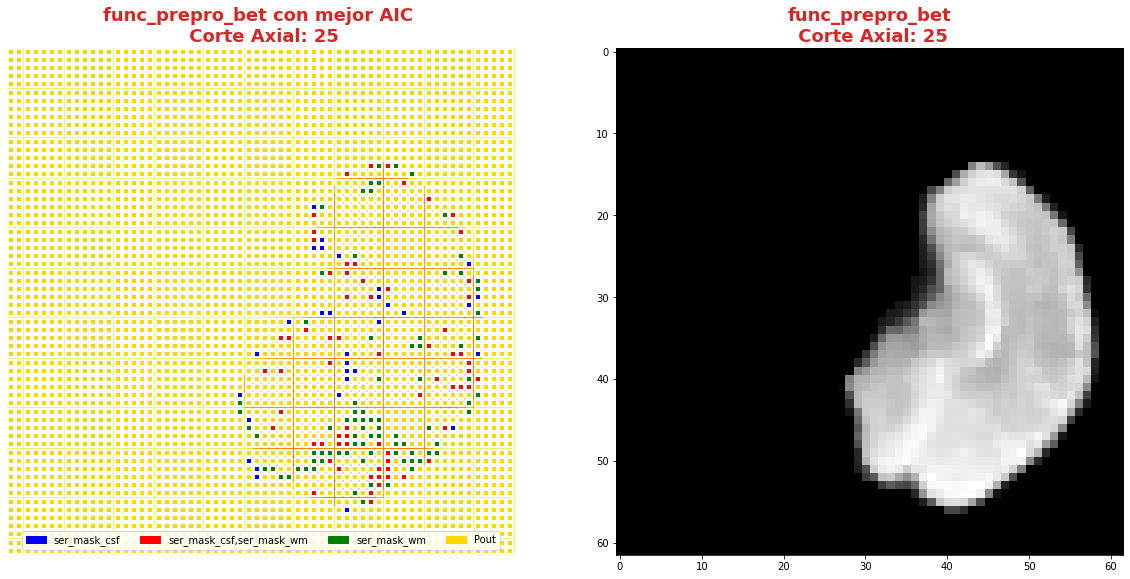

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


In [58]:
visual_analis_corte_sagital(df_sel=aic_p_voxels,
                          datos_img_fis=datos_func_orig, 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

#### Solo los modelos que se ajustan a wm

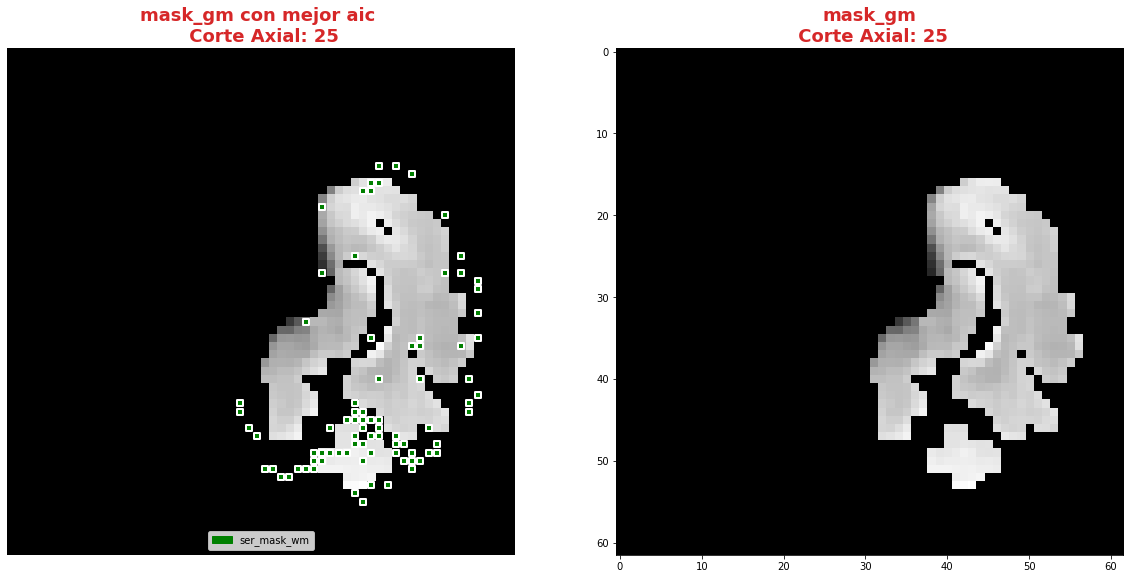

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
25,25,0,0,25,Pout
69,69,0,1,25,Pout
113,113,0,2,25,Pout
157,157,0,3,25,Pout
201,201,0,4,25,Pout
...,...,...,...,...,...
168941,168941,61,57,25,Pout
168985,168985,61,58,25,Pout
169029,169029,61,59,25,Pout


In [59]:
visual_solo_wm(df_sel=aic_p_voxels, 
                datos_img_fis=datos_mask_wm,
                vol=40, 
                corte_selec=corte_sagital)

## Visualizamos el resultado de la regresión lineal solo en los voxels de las mascaras del tejido cerebral

### Extraemos las posiciones de los voxels del corte seleccionado

#### GM

In [60]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel_gm  = voxels_gm[voxels_gm['x']==corte_sagital]
voxels_sel_gm

,voxel/serie,z,y,x
voxel/serie,,,,
69985,69985,25,40,25
70029,70029,25,41,25
70073,70073,25,42,25
70117,70117,25,43,25
70161,70161,25,44,25
...,...,...,...,...
132553,132553,48,36,25
132597,132597,48,37,25
135237,135237,49,35,25


#### CSF


In [61]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel_csf  = voxels_csf[voxels_csf['x']==corte_sagital]
voxels_sel_csf

,voxel/serie,z,y,x
voxel/serie,,,,
78301,78301,28,43,25
78345,78345,28,44,25
78389,78389,28,45,25
78433,78433,28,46,25
81029,81029,29,43,25
81073,81073,29,44,25
81117,81117,29,45,25
81161,81161,29,46,25
83757,83757,30,43,25


#### WM

In [62]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel_wm  = voxels_wm[voxels_wm['x']==corte_sagital]
voxels_sel_wm

,voxel/serie,z,y,x
voxel/serie,,,,
45521,45521,16,42,25
45565,45565,16,43,25
45609,45609,16,44,25
45653,45653,16,45,25
45697,45697,16,46,25
...,...,...,...,...
143773,143773,52,43,25
143817,143817,52,44,25
146413,146413,53,41,25


### Fusionamos y extraemos los valores del mejor AIC

#### GM

In [63]:
aic_p_voxels_gm = dataframe_posicion(voxel_posicion= voxels_sel_gm, 
                                   df_anali= analisis_p_aic, 
                                   carac= 'MODELO_P')
aic_p_voxels_gm

,voxel/serie,z,y,x,MODELO_P
69985,69985,25,40,25,ser_mask_csf
70029,70029,25,41,25,Pout
70073,70073,25,42,25,ser_mask_wm
70117,70117,25,43,25,Pout
70161,70161,25,44,25,Pout
...,...,...,...,...,...
132553,132553,48,36,25,Pout
132597,132597,48,37,25,"ser_mask_csf,ser_mask_wm"
135237,135237,49,35,25,Pout
135281,135281,49,36,25,Pout


#### CSF

In [64]:
aic_p_voxels_csf = dataframe_posicion(voxel_posicion= voxels_sel_csf,
                                      df_anali= analisis_p_aic, 
                                      carac= 'MODELO_P')
aic_p_voxels_csf

,voxel/serie,z,y,x,MODELO_P
78301,78301,28,43,25,"ser_mask_csf,ser_mask_wm"
78345,78345,28,44,25,Pout
78389,78389,28,45,25,Pout
78433,78433,28,46,25,Pout
81029,81029,29,43,25,Pout
81073,81073,29,44,25,Pout
81117,81117,29,45,25,ser_mask_csf
81161,81161,29,46,25,"ser_mask_csf,ser_mask_wm"
83757,83757,30,43,25,Pout
83801,83801,30,44,25,"ser_mask_csf,ser_mask_wm"


#### WM

In [65]:
aic_p_voxels_wm = dataframe_posicion(voxel_posicion= voxels_sel_wm, 
                                     df_anali= analisis_p_aic, 
                                     carac= 'MODELO_P')
aic_p_voxels_wm

,voxel/serie,z,y,x,MODELO_P
45521,45521,16,42,25,Pout
45565,45565,16,43,25,Pout
45609,45609,16,44,25,ser_mask_wm
45653,45653,16,45,25,ser_mask_wm
45697,45697,16,46,25,Pout
...,...,...,...,...,...
143773,143773,52,43,25,Pout
143817,143817,52,44,25,"ser_mask_csf,ser_mask_wm"
146413,146413,53,41,25,Pout
146457,146457,53,42,25,Pout


### Visualizamos

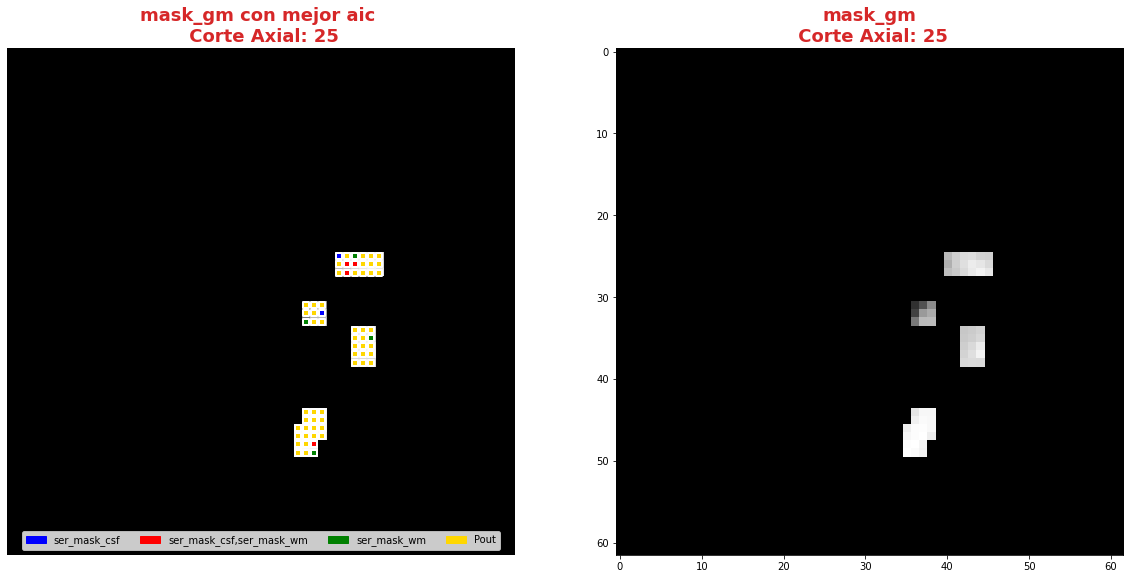

,voxel/serie,z,y,x,MODELO_P
69985,69985,25,40,25,ser_mask_csf
70029,70029,25,41,25,Pout
70073,70073,25,42,25,ser_mask_wm
70117,70117,25,43,25,Pout
70161,70161,25,44,25,Pout
...,...,...,...,...,...
132553,132553,48,36,25,Pout
132597,132597,48,37,25,"ser_mask_csf,ser_mask_wm"
135237,135237,49,35,25,Pout
135281,135281,49,36,25,Pout


In [66]:
visual_analis_mask(df_sel=aic_p_voxels_gm,
                          mascara='mask_gm', 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

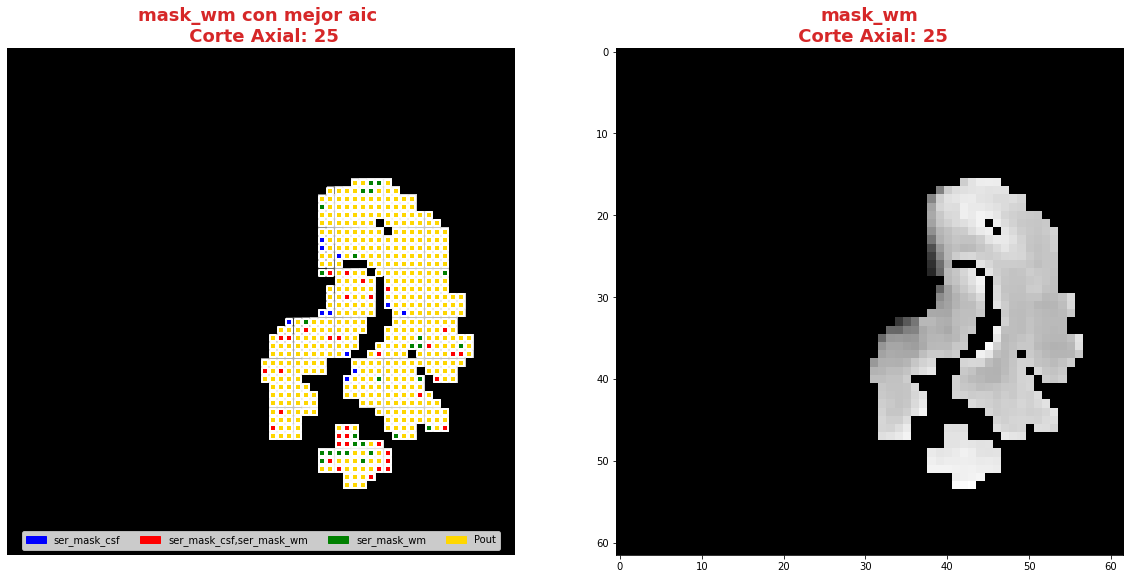

,voxel/serie,z,y,x,MODELO_P
45521,45521,16,42,25,Pout
45565,45565,16,43,25,Pout
45609,45609,16,44,25,ser_mask_wm
45653,45653,16,45,25,ser_mask_wm
45697,45697,16,46,25,Pout
...,...,...,...,...,...
143773,143773,52,43,25,Pout
143817,143817,52,44,25,"ser_mask_csf,ser_mask_wm"
146413,146413,53,41,25,Pout
146457,146457,53,42,25,Pout


In [67]:
visual_analis_mask(df_sel=aic_p_voxels_wm,
                          mascara='mask_wm', 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

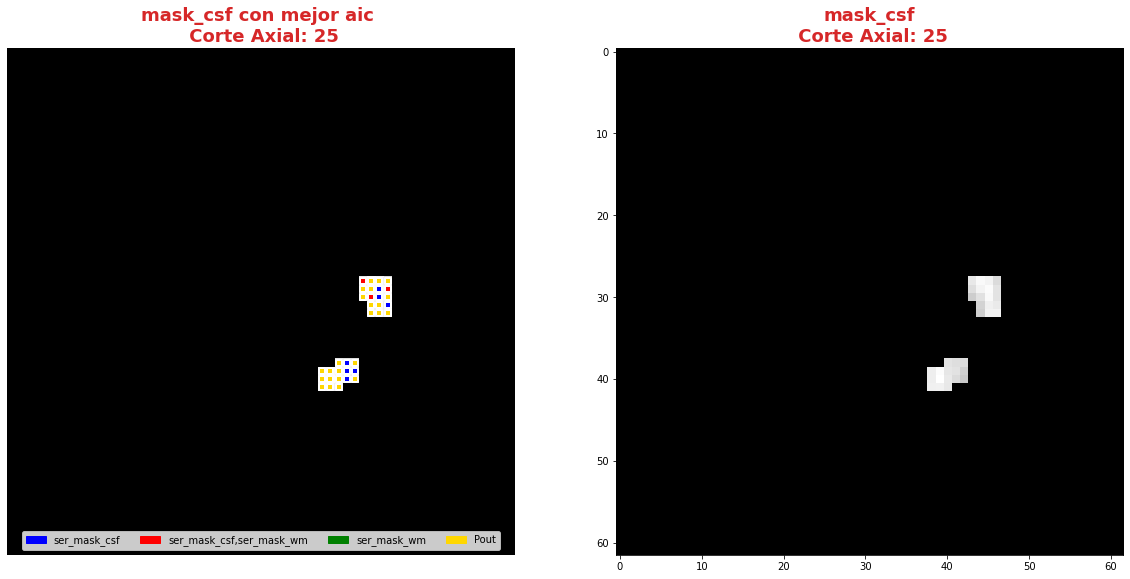

,voxel/serie,z,y,x,MODELO_P
78301,78301,28,43,25,"ser_mask_csf,ser_mask_wm"
78345,78345,28,44,25,Pout
78389,78389,28,45,25,Pout
78433,78433,28,46,25,Pout
81029,81029,29,43,25,Pout
81073,81073,29,44,25,Pout
81117,81117,29,45,25,ser_mask_csf
81161,81161,29,46,25,"ser_mask_csf,ser_mask_wm"
83757,83757,30,43,25,Pout
83801,83801,30,44,25,"ser_mask_csf,ser_mask_wm"


In [68]:
visual_analis_mask(df_sel=aic_p_voxels_csf,
                          mascara='mask_csf', 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

## ANALISAMOS EL CORTE SAGITAL QUE CONTIENE MAYOR CANTIDAD DE VOXELS CORRESPONDIENTES A LA GM.

### Dataframe de la cantidad de voxels que dan forma a la GM en cada corte de la imagen mask_gm

In [69]:
voxels_gm

,voxel/serie,z,y,x
voxel/serie,,,,
69984,69984,25,40,24
69985,69985,25,40,25
69986,69986,25,40,26
70028,70028,25,41,24
70029,70029,25,41,25
...,...,...,...,...
138012,138012,50,36,28
138013,138013,50,36,29
138054,138054,50,37,26


In [70]:
cant_vox_cort_gm = voxels_gm.x.value_counts()
cant_vox_cort_gm = pd.DataFrame(cant_vox_cort_gm)
cant_vox_cort_gm.columns = ['cantidad_voxels_gm']
cant_vox_cort_gm.index.name = 'corte_sagital'
cant_vox_cort_gm = cant_vox_cort_gm.sort_index() #ordenamos por indice
cant_vox_cort_gm

,cantidad_voxels_gm
corte_sagital,
7,9
8,9
9,36
10,39
11,58
12,49
13,61
14,60
15,86


In [71]:
cant_vox_cort_gm.describe()

,cantidad_voxels_gm
count,32.000000
mean,56.062500
std,28.979345
min,9.000000
25%,38.250000
50%,58.000000
75%,79.500000
max,109.000000


### Extraemos el indice del corte que contiene la mayor cantidad de voxels a GM

In [72]:
# SOLO PARA VISUALIZAR LA DATA
cant_vox_cort_gm.loc[cant_vox_cort_gm['cantidad_voxels_gm']==cant_vox_cort_gm.max()[0]]

,cantidad_voxels_gm
corte_sagital,
28,109


In [73]:
# Extraemos el indice
indi_max = cant_vox_cort_gm[['cantidad_voxels_gm']].idxmax() 
indi_max = indi_max[0]
indi_max

28

## Seleccionar un corte y extraemos las series correspondientes a ese corte

### Asignamos el indice a la variable, corte_sagital

In [74]:
'''
Indicamos el corte sagital
'''
corte_sagital = indi_max
corte_sagital

28

### Extraemos las series que corresponden al corte seleccionado en la imagen funcional

#### Extraemos las posiciones de los voxels del corte seleccionado

In [75]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel  = voxels_func[voxels_func['x']==corte_sagital]
voxels_sel

,voxel/serie,z,y,x
voxel/serie,,,,
28,28,0,0,28
72,72,0,1,28
116,116,0,2,28
160,160,0,3,28
204,204,0,4,28
...,...,...,...,...
168944,168944,61,57,28
168988,168988,61,58,28
169032,169032,61,59,28


#### Extraemos las series que corresponden a ese corte

In [76]:
'''
Extraemos una lista del indice
'''
lista_indice = voxels_sel[voxels_sel['x']==corte_sagital].index.to_list()


'''
Extraemos las series del corte seleccionado.
Cuando queramos usar los índices de las columnas para extraer las series, 
podemos usar iloc()
'''
df_func_corte = df_func.iloc[:,lista_indice]
df_func_corte

,28,72,116,160,204,248,...,168900,168944,168988,169032,169076,169120
0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
193,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
194,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
num_ser = df_func_corte.shape[1]
print('El (los) corte(s) tiene(n) ---> '+ str(num_ser) + ' voxels/series')

El (los) corte(s) tiene(n) ---> 3844 voxels/series


## Definimos DataFrame con la variable depiendiente y las variables independientes

In [78]:
'''
DF con la variable dependiente
'''
df_var_depen = df_func_corte

'''
DF con la variables indeopendientes (series promedio global csf y wm)
'''

df_var_indep = pd.merge(df_csf,df_wm,
                        right_index=True,left_index=True)
df_var_indep 

,ser_mask_csf,ser_mask_wm
0,608.445532,545.955034
1,607.909773,545.948231
2,608.436558,545.871291
3,606.512312,545.199905
4,607.254498,545.471301
...,...,...
191,608.981452,545.935069
192,609.086091,545.772953
193,608.484934,545.998505
194,608.888241,546.368934


## Regresión Lineal OLS al corte seleccionado

Usaremos el módulo statsmodels de Python para implementar el método Ordinary Least Squares( OLS ) de regresión lineal. Para la primera Validación, usaremos la data de *df_suma_random*, sin agregar series aleatorias adicionales.

### Extraemos las combinaciones

Para extraer las posibles combinaciones o modelos que me pueden predecir la serie promedio global de la GM (*ser_mask_gm*), en esta primera validación tomamos en cuenta la serie promedio global de la CSF y WM (*ser_mask_csf* y *ser_mask_wm*) para la construcción de los modelos.

#### Lista de series que forman parte de las combinaciones ó modelos

Para extraer la lista que formaran parte de las combinaciones ó modelos, usamos la funcion *lista_dataframe*. Ahora, debemos tener claro que dataframe usaremos como input, para asi poder definir el input de la función *eliminar*. Por ejemplo, si usamos el dataframe *df_ser_random* y no queremos que la serie error sea parte del modelo, el input *eliminar* debe ser la lista *eliminar=['error']*; si usamos el dataframe *df_suma_random* y no queremos que la serie error sea parte del modelo, asi como la *ser_sum* ya que es la que queremos predecir, el input *eliminar* debe ser la lista *eliminar=['ser_sum', 'error']*

In [79]:
'''
Aplicamos funcion lista_dataframe
'''
list_ser = lista_dataframe(df=df_var_indep,
                           eliminar='')

list_ser

['ser_mask_csf', 'ser_mask_wm']

#### Combinaciones de las series para generar ser_tiem_sum

In [80]:
'''
Posibles combinaciones de las series para generar ser_tiem_sum
'''
#ejecutamos funcion potencia
combi = potencia(list_ser)
combi

[[], ['ser_mask_csf'], ['ser_mask_wm'], ['ser_mask_csf', 'ser_mask_wm']]

Como al ejecutar la función potencia, entre los subconjuntos esta el conjunto vacio, lo eliminamos de nuestra lista

In [81]:
'''
Eliminamos primer elemento lista combi
'''
combi.pop(0)

print('posibles combinaciones de las series brain:\n', combi, '\n\n')

print('cantidad de combinaciones/modelos:\n\n', len(combi))

posibles combinaciones de las series brain:
 [['ser_mask_csf'], ['ser_mask_wm'], ['ser_mask_csf', 'ser_mask_wm']] 


cantidad de combinaciones/modelos:

 3


#### Generamos un DF de las combinaciones/modelos para un documento

In [82]:
pd.set_option( 'max_colwidth', 1)
crear_df_combi(lista_combi=combi, 
               columnas = 1)

,Combinaciones / Modelos
,$\beta$0 + $\beta$1 ser_mask_csf
,$\beta$0 + $\beta$1 ser_mask_csf + $\beta$2 ser_mask_wm
,$\beta$0 + $\beta$1 ser_mask_wm


### Aplicamos el modelo OLS

#### Ejecutamos la función  *best_osl*  para determinar el mejor modelo mediante modelo de regresión OSL

In [83]:
modelo_regre = best_osl(df_depen=df_var_depen, 
                        df_indep=df_var_indep, 
                        var_depen='ser_mask_gm',
                        lista_combi=combi)

/home/aracena/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/aracena/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [84]:
mejor_aic = modelo_regre[0]
aic_all = modelo_regre[1]
mejor_r2 = modelo_regre[2]
r2_all = modelo_regre[3]
mejor_r2_ajus = modelo_regre[4]
r2_ajus_all = modelo_regre[5]

In [85]:
mejor_aic

,serie,MODELO,AIC,resultado_regresión
0,28,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3cd2db0d0>
1,72,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3cd2e0ac0>
2,116,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff330c8a5e0>
3,160,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3cd2e0af0>
4,204,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff3cd2ded60>
...,...,...,...,...
3839,168944,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff38d0b4fa0>
3840,168988,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff38d0662e0>
3841,169032,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff38d0a4310>
3842,169076,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7ff38d0b48b0>


In [86]:
pd.set_option('display.max_colwidth', 60)
aic_all

,serie,MODELO,AIC,resultado_regresión
0,28,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
1,28,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
2,28,ser_mask_wm,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
3,72,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
4,72,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
...,...,...,...,...
11527,169076,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
11528,169076,ser_mask_wm,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
11529,169120,ser_mask_csf,-inf,<statsmodels.regression.linear_model.RegressionResultsWr...
11530,169120,"ser_mask_csf,ser_mask_wm",-inf,<statsmodels.regression.linear_model.RegressionResultsWr...


#### Aplicamos función *analisi_p* para extraer los valores p de los regresores, y confirmar mejor modelo

In [87]:
analisis_p_aic = analisi_p(df_anali=mejor_aic, 
                           nivel_signif=0.05)

analisis_p_aic

,serie,MODELO,AIC,const,ser_mask_csf,ser_mask_wm,valores_p_regresores,suma_evaluación,MODELO_P
0,28,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
1,72,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
2,116,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3,160,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
4,204,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
...,...,...,...,...,...,...,...,...,...
3839,168944,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3840,168988,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3841,169032,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
3842,169076,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout


In [88]:
analisis_p_aic.set_index('serie', inplace = True)
analisis_p_aic

,MODELO,AIC,const,ser_mask_csf,ser_mask_wm,valores_p_regresores,suma_evaluación,MODELO_P
serie,,,,,,,,
28,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
72,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
116,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
160,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
204,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
...,...,...,...,...,...,...,...,...
168944,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
168988,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout
169032,ser_mask_csf,-inf,NaN,NaN,NaN,"[nan, nan]",2,Pout


## Extraemos el resultado del anlisis p y con la posicion de los voels de la serie

In [89]:
aic_p_voxels = dataframe_posicion(voxel_posicion= voxels_sel, 
                                   df_anali= analisis_p_aic, 
                                   carac= 'MODELO_P')
aic_p_voxels

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
28,28,0,0,28,Pout
72,72,0,1,28,Pout
116,116,0,2,28,Pout
160,160,0,3,28,Pout
204,204,0,4,28,Pout
...,...,...,...,...,...
168944,168944,61,57,28,Pout
168988,168988,61,58,28,Pout
169032,169032,61,59,28,Pout


## Visualizamos el resultado de la regesión lineal en el corte seleccionado de la imagen funcional preprocesada

### Creamos una DF de los colores

In [90]:
'''
Conocemos las posibles combinaciones y creamos una lista 1d
'''
lista_com = []
for i in range(len(combi)):
    co = combi[i][0]
    le = len(combi[i])
    for j in range(le-1):
        co = co + ',' +combi[i][j+1]
    lista_com.append(co)
lista_com

['ser_mask_csf', 'ser_mask_csf,ser_mask_wm', 'ser_mask_wm']

In [91]:
# agregamos a la lista 'Pout'
lista_com.append('Pout')
lista_com

['ser_mask_csf', 'ser_mask_csf,ser_mask_wm', 'ser_mask_wm', 'Pout']

In [92]:
'''
Creamos un DF con las combinaciones
'''
df_color = pd.DataFrame(lista_com)
df_color.columns = ['MODELO']
df_color.set_index('MODELO', inplace=True) # Convertimos la columna 'MODELO' en indice
# agregamos columna vacia de color
df_color['color'] = ''
df_color

,color
MODELO,
ser_mask_csf,
"ser_mask_csf,ser_mask_wm",
ser_mask_wm,
Pout,


In [93]:
'''
Asignamos colores preestablecidos;
estos colores se pueden modificar segun lo que se desee visualizar
'''
df_color['color']['ser_mask_csf'] = 'blue'
df_color['color']['ser_mask_wm'] = 'green'
df_color['color']['ser_mask_csf,ser_mask_wm'] = 'red'
df_color['color']['Pout'] = 'gold'

In [94]:
df_color['color']['Pout']

'gold'

In [95]:
df_color

,color
MODELO,
ser_mask_csf,blue
"ser_mask_csf,ser_mask_wm",red
ser_mask_wm,green
Pout,gold


### Visualizamos con la imagen funcional preprocesada bet

#### Visualización de todos los modelos

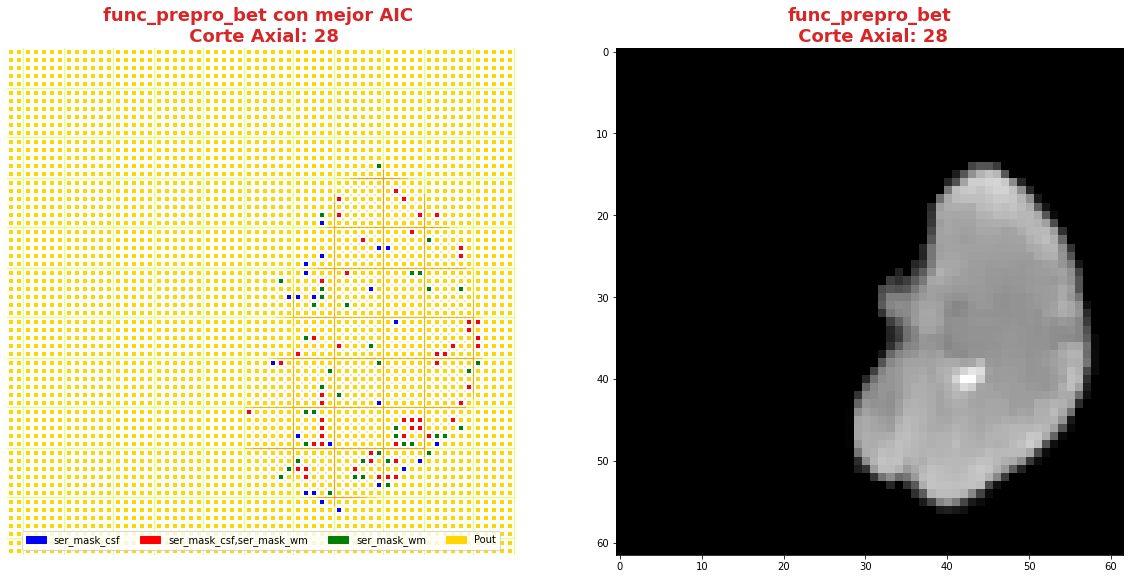

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
28,28,0,0,28,Pout
72,72,0,1,28,Pout
116,116,0,2,28,Pout
160,160,0,3,28,Pout
204,204,0,4,28,Pout
...,...,...,...,...,...
168944,168944,61,57,28,Pout
168988,168988,61,58,28,Pout
169032,169032,61,59,28,Pout


In [96]:
visual_analis_corte_sagital(df_sel=aic_p_voxels,
                          datos_img_fis=datos_func_orig, 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

#### Solo los models que se ajustan a wm

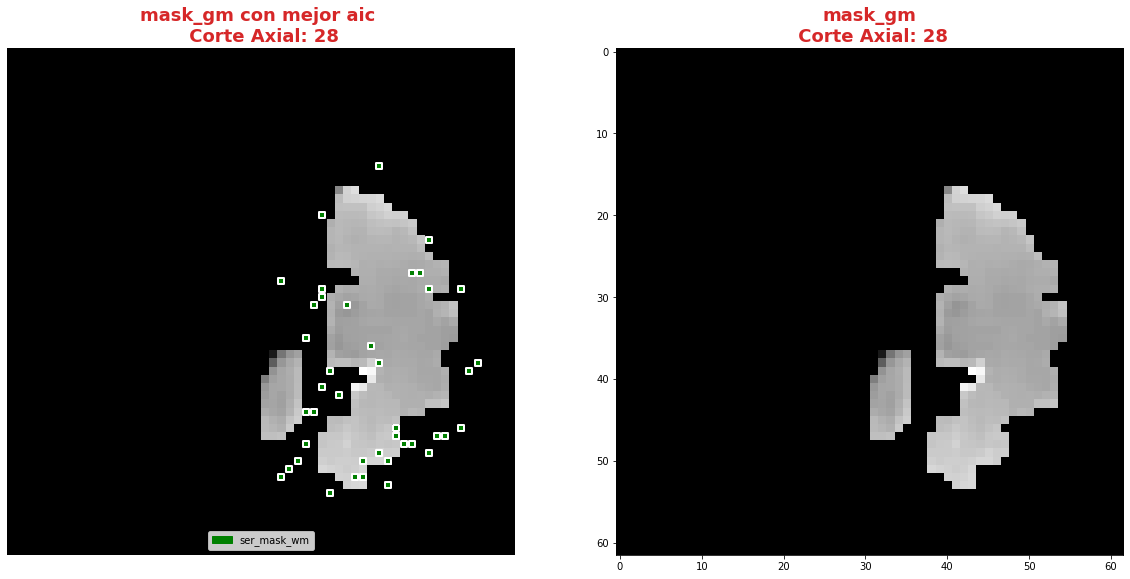

,voxel/serie,z,y,x,MODELO_P
voxel/serie,,,,,
28,28,0,0,28,Pout
72,72,0,1,28,Pout
116,116,0,2,28,Pout
160,160,0,3,28,Pout
204,204,0,4,28,Pout
...,...,...,...,...,...
168944,168944,61,57,28,Pout
168988,168988,61,58,28,Pout
169032,169032,61,59,28,Pout


In [97]:
visual_solo_wm(df_sel=aic_p_voxels, 
                datos_img_fis=datos_mask_wm,
                vol=40, 
                corte_selec=corte_sagital)

## Visualizamos el resultado de la regresión lineal solo en los voxels de las mascaras del tejido cerebral

### Extraemos las posiciones de los voxels del corte seleccionado

#### GM

In [98]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel_gm  = voxels_gm[voxels_gm['x']==corte_sagital]
voxels_sel_gm

,voxel/serie,z,y,x
voxel/serie,,,,
72672,72672,26,39,28
72716,72716,26,40,28
72760,72760,26,41,28
75400,75400,27,39,28
75444,75444,27,40,28
...,...,...,...,...
135328,135328,49,37,28
137924,137924,50,34,28
137968,137968,50,35,28


#### CSF


In [99]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel_csf  = voxels_csf[voxels_csf['x']==corte_sagital]
voxels_sel_csf

,voxel/serie,z,y,x
voxel/serie,,,,
102900,102900,37,44,28
102944,102944,37,45,28
102988,102988,37,46,28
105540,105540,38,42,28
105584,105584,38,43,28
105628,105628,38,44,28
105672,105672,38,45,28
105716,105716,38,46,28
108180,108180,39,40,28


#### WM

In [100]:
'''
Extraemos las posiciones de los voxels del corte seleccionado
'''
voxels_sel_wm  = voxels_wm[voxels_wm['x']==corte_sagital]
voxels_sel_wm

,voxel/serie,z,y,x
voxel/serie,,,,
48164,48164,17,40,28
48208,48208,17,41,28
48252,48252,17,42,28
50892,50892,18,40,28
50936,50936,18,41,28
...,...,...,...,...
143732,143732,52,42,28
143776,143776,52,43,28
146416,146416,53,41,28


### Fusionamos y extraemos los valores del mejor AIC

#### GM

In [101]:
aic_p_voxels_gm = dataframe_posicion(voxel_posicion= voxels_sel_gm, 
                                   df_anali= analisis_p_aic, 
                                   carac= 'MODELO_P')
aic_p_voxels_gm

,voxel/serie,z,y,x,MODELO_P
72672,72672,26,39,28,Pout
72716,72716,26,40,28,Pout
72760,72760,26,41,28,Pout
75400,75400,27,39,28,Pout
75444,75444,27,40,28,Pout
...,...,...,...,...,...
135328,135328,49,37,28,Pout
137924,137924,50,34,28,Pout
137968,137968,50,35,28,ser_mask_wm
138012,138012,50,36,28,Pout


#### CSF

In [102]:
aic_p_voxels_csf = dataframe_posicion(voxel_posicion= voxels_sel_csf,
                                      df_anali= analisis_p_aic, 
                                      carac= 'MODELO_P')
aic_p_voxels_csf

,voxel/serie,z,y,x,MODELO_P
102900,102900,37,44,28,Pout
102944,102944,37,45,28,Pout
102988,102988,37,46,28,Pout
105540,105540,38,42,28,Pout
105584,105584,38,43,28,Pout
105628,105628,38,44,28,Pout
105672,105672,38,45,28,ser_mask_wm
105716,105716,38,46,28,Pout
108180,108180,39,40,28,Pout
108224,108224,39,41,28,Pout


#### WM

In [103]:
aic_p_voxels_wm = dataframe_posicion(voxel_posicion= voxels_sel_wm, 
                                     df_anali= analisis_p_aic, 
                                     carac= 'MODELO_P')
aic_p_voxels_wm

,voxel/serie,z,y,x,MODELO_P
48164,48164,17,40,28,Pout
48208,48208,17,41,28,Pout
48252,48252,17,42,28,Pout
50892,50892,18,40,28,"ser_mask_csf,ser_mask_wm"
50936,50936,18,41,28,Pout
...,...,...,...,...,...
143732,143732,52,42,28,ser_mask_wm
143776,143776,52,43,28,ser_mask_wm
146416,146416,53,41,28,Pout
146460,146460,53,42,28,Pout


### Visualizamos

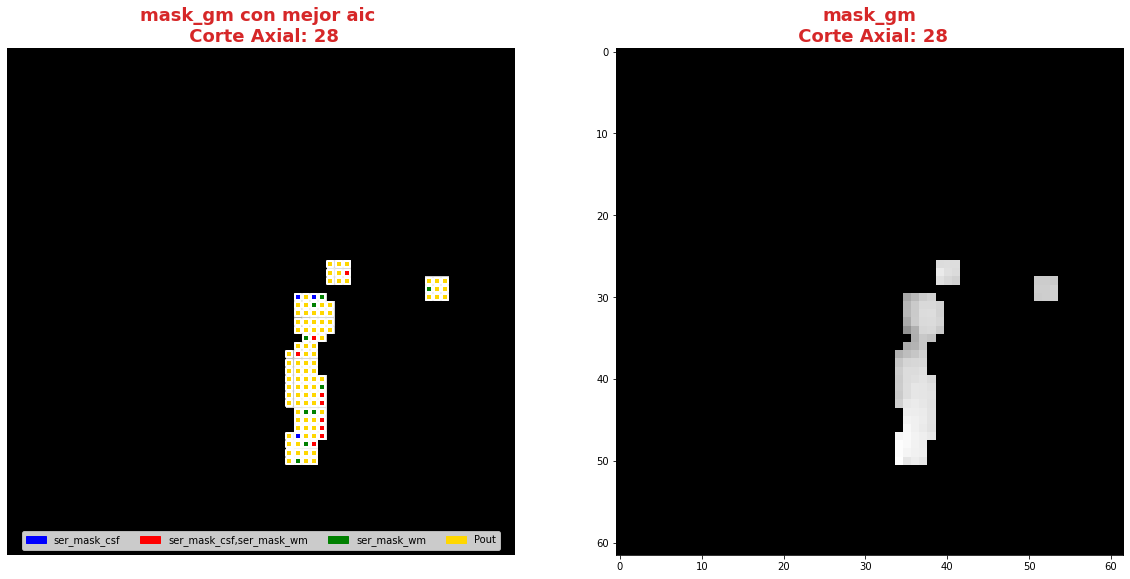

,voxel/serie,z,y,x,MODELO_P
72672,72672,26,39,28,Pout
72716,72716,26,40,28,Pout
72760,72760,26,41,28,Pout
75400,75400,27,39,28,Pout
75444,75444,27,40,28,Pout
...,...,...,...,...,...
135328,135328,49,37,28,Pout
137924,137924,50,34,28,Pout
137968,137968,50,35,28,ser_mask_wm
138012,138012,50,36,28,Pout


In [104]:
visual_analis_mask(df_sel=aic_p_voxels_gm,
                          mascara='mask_gm', 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

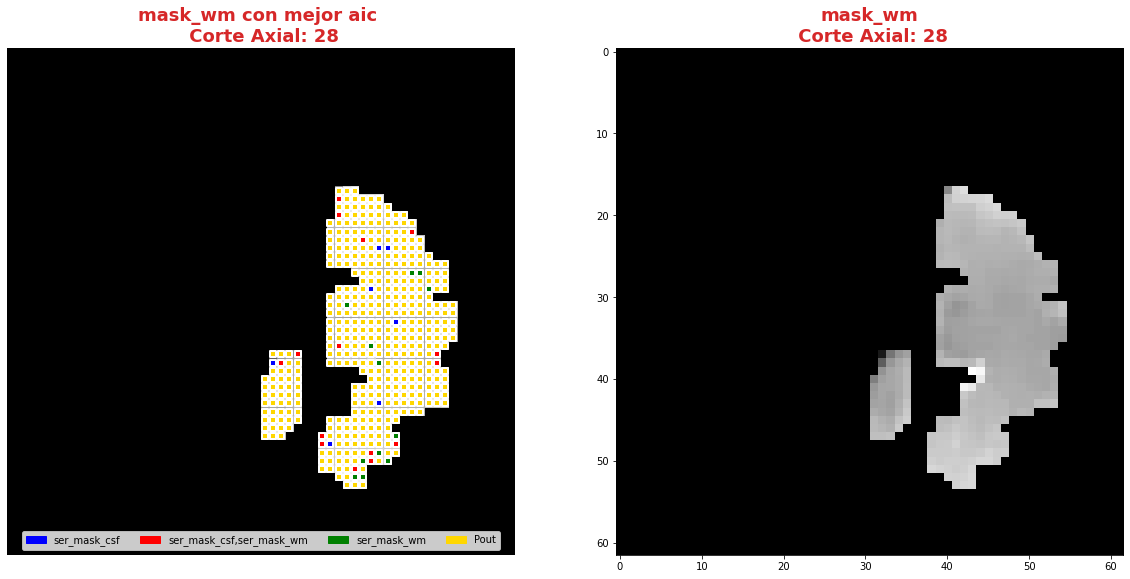

,voxel/serie,z,y,x,MODELO_P
48164,48164,17,40,28,Pout
48208,48208,17,41,28,Pout
48252,48252,17,42,28,Pout
50892,50892,18,40,28,"ser_mask_csf,ser_mask_wm"
50936,50936,18,41,28,Pout
...,...,...,...,...,...
143732,143732,52,42,28,ser_mask_wm
143776,143776,52,43,28,ser_mask_wm
146416,146416,53,41,28,Pout
146460,146460,53,42,28,Pout


In [105]:
visual_analis_mask(df_sel=aic_p_voxels_wm,
                          mascara='mask_wm', 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

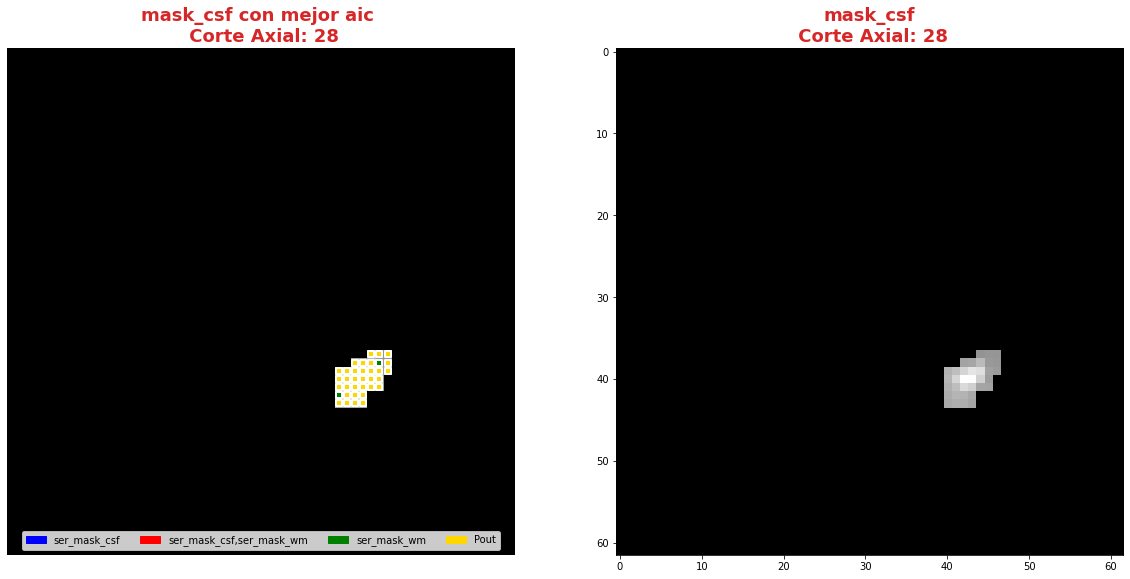

,voxel/serie,z,y,x,MODELO_P
102900,102900,37,44,28,Pout
102944,102944,37,45,28,Pout
102988,102988,37,46,28,Pout
105540,105540,38,42,28,Pout
105584,105584,38,43,28,Pout
105628,105628,38,44,28,Pout
105672,105672,38,45,28,ser_mask_wm
105716,105716,38,46,28,Pout
108180,108180,39,40,28,Pout
108224,108224,39,41,28,Pout


In [106]:
visual_analis_mask(df_sel=aic_p_voxels_csf,
                          mascara='mask_csf', 
                          vol=40,
                          corte_selec=corte_sagital,
                          df_color=df_color)

## Tiempo de ejecución

In [107]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n\n', tiempo, 'seg\n', tiempo/60, 'min\n',      
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n\n', tiempo2, 'seg\n', tiempo2/60, 'min\n',   
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución

 593.7891054153442 seg
 9.896485090255737 min
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU

 590.717419956 seg
 9.8452903326 min
 ---------------------------------------



## Fin